# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 1

# **Predição de séries temporais empregando vários tipos de modelos**
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Mercado de ações (NYSE: The New York Stock Exchange)
#### Parcialmente baseado em https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Guilherme Rosa 

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/'

# Specific imports
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# import all stock prices 
df = pd.read_csv(path + "prices-split-adjusted.csv", index_col = 0)
print(df.info())
print('+---------------------------------------------------------------------------------+')
print(df.head())
print('+---------------------------------------------------------------------------------+')

# number of different stocks
print('\nNumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])
print('+---------------------------------------------------------------------------------+')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB
None
+---------------------------------------------------------------------------------+
           symbol        open       close         low        high     volume
date                                                                        
2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
2016-01-08   WLTW  115.480003  116.620003  113.5000

### 6.3. Exibindo o comportamento temporal de várias séries associadas à ação EQIX

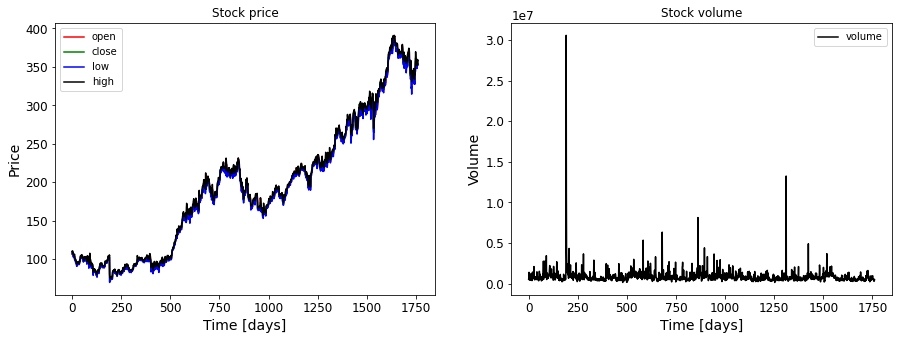

In [3]:
plt.figure(figsize=(15, 5));

plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best');

### 6.4. Escolha do preço de fechamento da ação EQIX e preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste
##### Cabe comentar que os dados de teste não deveriam participar de nenhuma etapa de pré-processamento, pois, assim, têm o potencial de interferir no andamento do treinamento, desvirtuando o seu papel de apenas servirem para teste de desempenho. Cometeremos essa "mancada" metodológica para despertar o(a) aluno(a) para a questão.

In [4]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = np.array(stock) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    # Choice of the close behavior
    
    x_train = data[:train_set_size,:-1,1]
    y_train = data[:train_set_size,-1,1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,1]
    
    x_test = data[train_set_size+valid_set_size:,:-1,1]
    y_test = data[train_set_size+valid_set_size:,-1,1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P1_x_train.txt', x_train)
    np.savetxt('Q6P1_y_train.txt', y_train)
    np.savetxt('Q6P1_x_valid.txt', x_valid)
    np.savetxt('Q6P1_y_valid.txt', y_valid)
    np.savetxt('Q6P1_x_test.txt', x_test)
    np.savetxt('Q6P1_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
print('Chosen stock is EQIX')
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols[1])

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

Chosen stock is EQIX
df_stock.columns.values =  close
x_train.shape =  (1393, 20)
y_train.shape =  (1393, 1)
x_valid.shape =  (174, 20)
y_valid.shape =  (174, 1)
x_test.shape =  (174, 20)
y_test.shape =  (174, 1)


### 6.5. Visualização do comportamento da série temporal normalizada

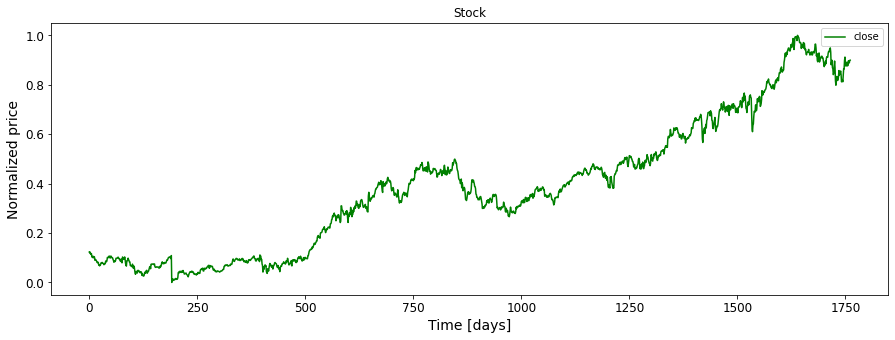

In [5]:
plt.figure(figsize=(15, 5));

plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price')
plt.legend(loc='best')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-1.73993876e-02 -7.50066948e-04 -1.72042605e-02 -3.09133810e-03
  7.19680083e-02 -4.14608411e-02  6.27850574e-03  3.20712481e-02
 -5.12410805e-02 -4.49534424e-02  7.63970457e-02  2.38739465e-03
 -2.37630945e-02  4.03452307e-02  1.52671193e-03 -2.65006693e-02
  6.09614856e-02 -2.34004550e-02 -4.62112083e-03  9.62510603e-01
  0.00000000e+00]


#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
8.2815338977819e-05
EQM final de validação após o término do treinamento - Preditor Linear
0.00027770088993386247
EQM final de teste após o término do treinamento - Preditor Linear
0.00021231229767131773


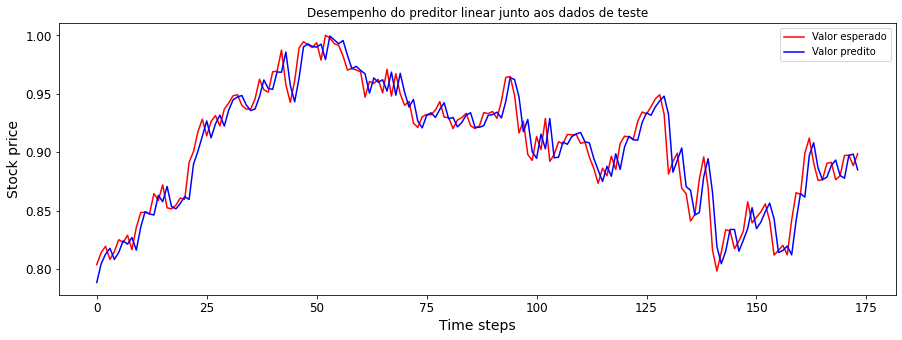

In [8]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [9]:
EPOCHS = 20
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/20
44/44 [==============================] - 0s 8ms/step - loss: 0.0141 - val_loss: 0.0176
Epoch 2/20
44/44 [==============================] - 0s 4ms/step - loss: 5.2879e-04 - val_loss: 0.0064
Epoch 3/20
44/44 [==============================] - 0s 4ms/step - loss: 3.6791e-04 - val_loss: 0.0036
Epoch 4/20
44/44 [==============================] - 0s 4ms/step - loss: 3.1558e-04 - val_loss: 0.0036
Epoch 5/20
44/44 [==============================] - 0s 4ms/step - loss: 2.8513e-04 - val_loss: 0.0028
Epoch 6/20
44/44 [==============================] - 0s 4ms/step - loss: 2.4944e-04 - val_loss: 0.0026
Epoch 7/20
44/44 [==============================] - 0s 4ms/step - loss: 2.2248e-04 - val_loss: 0.0015
Epoch 8/20
44/44 [==============================] - 0s 3ms/step - loss: 2.1365e-04 - val_loss: 0.0019
Epoch 9/20
44/44 [==============================] - 0s 4ms/step - loss: 1.7862e-04 - val_loss: 0.0011
Epoch 10/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6849e-04 - 

In [10]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2688      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MSE para o preditor MLP

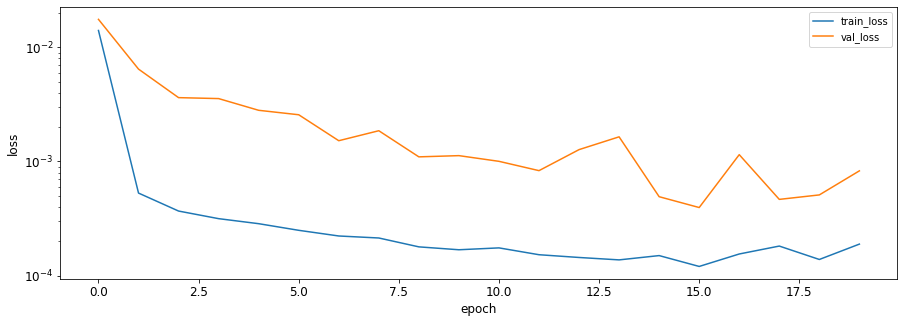

In [11]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [12]:
# weights = model_MLP.get_weights()
# print(weights[0])
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.00012126941575309851
EQM final de validação após o término do treinamento - Preditor MLP
0.00039494186614409763
EQM final de teste após o término do treinamento - Preditor MLP
0.0008925052943247461


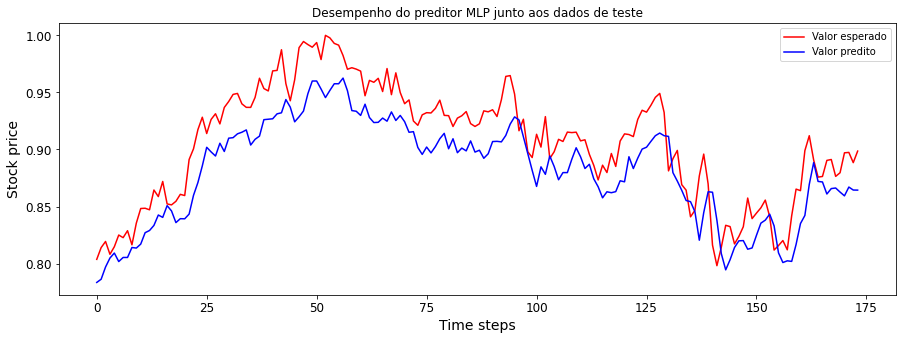

In [13]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [ ]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)

x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)

x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)


In [ ]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MSE para o preditor não-linear Simple RNN

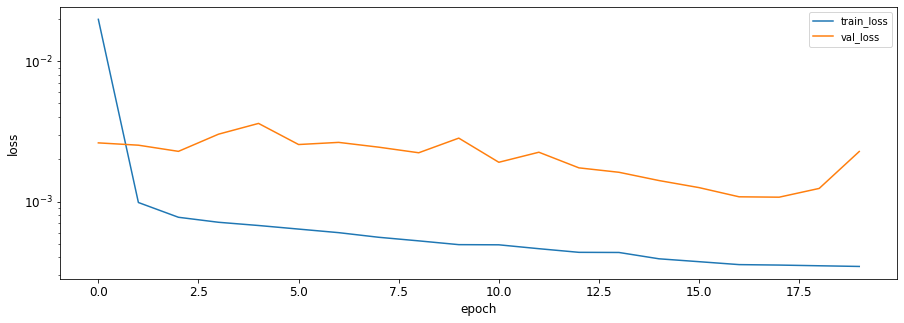

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.00035963674026668853
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.0010747979646682055
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.006695148373932401


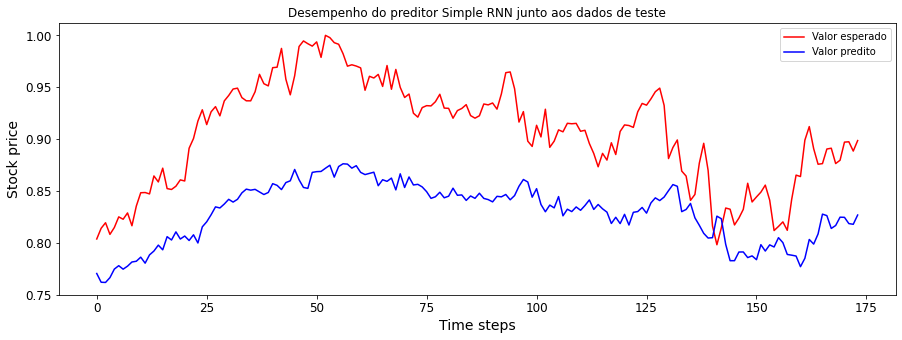

In [ ]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [14]:
x_train = np.asarray(x_train)

if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)

if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)

if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)
Epoch 1/20
44/44 [==============================] - 1s 28ms/step - loss: 0.0202 - val_loss: 0.0465
Epoch 2/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0227
Epoch 3/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0037 - val_loss: 0.0146
Epoch 4/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 5/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 6/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 7/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 9/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 10/20
44/44 [======================

In [15]:
model_RNN2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           21        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MSE para o preditor não-linear com bloco LSTM GRU

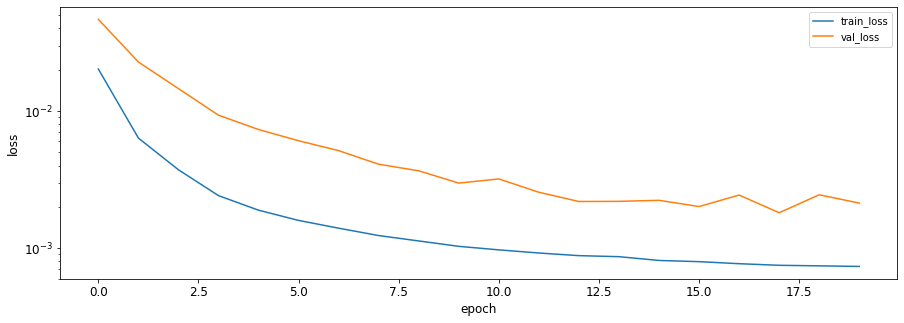

In [16]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [17]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)

print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)

print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
44/44 [==============================] - 0s 5ms/step - loss: 7.5924e-04
EQM final de validação após o término do treinamento - Preditor LSTM GRU
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
EQM final de teste após o término do treinamento - Preditor LSTM GRU
6/6 [==============================] - 0s 4ms/step - loss: 0.0019


0.00193208665587008

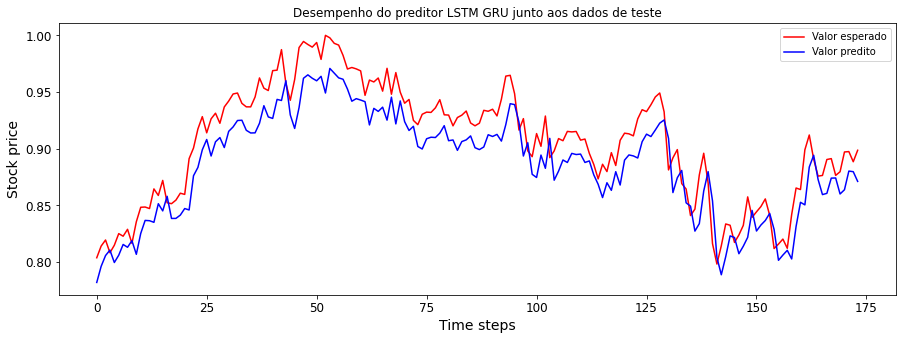

In [18]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len - 1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [19]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [20]:
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [21]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/20
44/44 [==============================] - 0s 10ms/step - loss: 0.0217 - val_loss: 0.0263
Epoch 2/20
44/44 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 3/20
44/44 [==============================] - 0s 5ms/step - loss: 6.2481e-04 - val_loss: 0.0012
Epoch 4/20
44/44 [==============================] - 0s 5ms/step - loss: 4.5080e-04 - val_loss: 0.0011
Epoch 5/20
44/44 [==============================] - 0s 5ms/step - loss: 4.5177e-04 - val_loss: 0.0011
Epoch 6/20
44/44 [==============================] - 0s 4ms/step - loss: 4.4309e-04 - val_loss: 0.0011
Epoch 7/20
44/44 [==============================] - 0s 5ms/step - loss: 4.4170e-04 - val_loss: 0.0011
Epoch 8/20
44/44 [==============================] - 0s 4ms/step - loss: 4.3822e-04 - val_loss: 0.0011
Epoch 9/20
44/44 [==============================] - 0s 5ms/step - loss: 4.3663e-04 - val_loss: 0.0011
Epoch 10/20
44/44 [==============================] - 0s 5ms/step - loss: 4.2625e-04 - val

#### 6.10.1. Carregando o modelo com o menor MSE para o preditor CNN

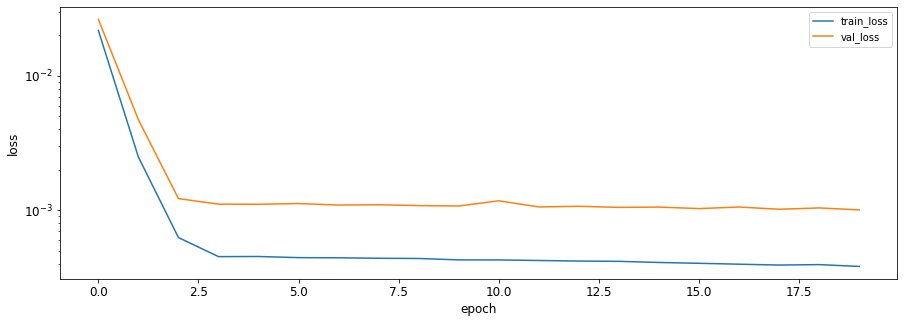

In [22]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [23]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.0003778597012556399
EQM final de validação após o término do treinamento - Preditor CNN
0.0010038967283688895
EQM final de teste após o término do treinamento - Preditor CNN
0.0009099271425132133


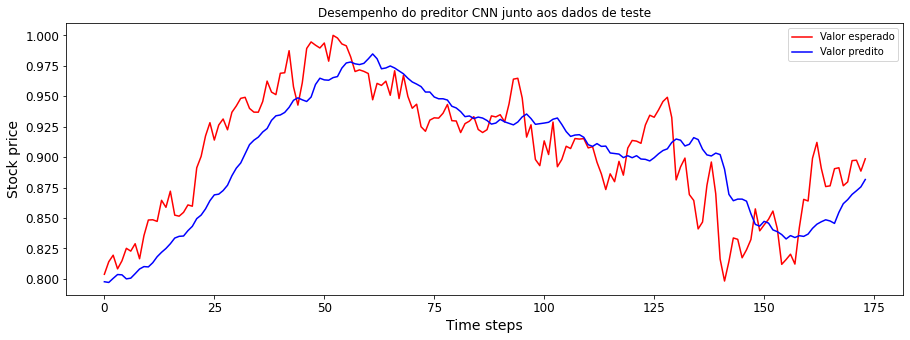

In [24]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

# **Resolução da atividade:**

##### **6.1.1 - Forneça o notebook devidamente executado, contendo, ao final, um resumo geral do que foi trabalhado em cada seção.**


**Seção 6.1. Importações e definições:**

- Nesta seção são feitas as importações dos módulos necessários para implementação das funcionalidades do código.
  
- Exemplos:
    
  - Numpy: tratamento de arrays N-dimensionais.
  - Pandas: download e manipulação da base de dados.
  - Scikit-learn: utilizado para o pré-processamento dos dados da série temporal e na implementação do preditor linear.
  - Tensorflow e Keras: utilizado para a implementação e treinamento dos preditores não-lineares.
  - Matplotlib: utilizado para a visualização dos dados.

**Seção 6.2. Carregando a base de dados e apresentando sua composição:**

- A base de dados *prices-split-adjusted.csv* é composta por 851264 instâncias (linhas) caracterizadas por 6 atributos (colunas):

  - *Symbol*: Sigla da ação. 
  - *Open*: Preço diário da ação na abertura do mercado.
  - *Close*: Preço diário da ação no fechamento do mercado.
  - *Low*: Menor preço diário da ação.
  - *High*: Maior preço diário da ação.
  - *Volume*: Quantidade diária de ações comercializadas no mercado.
  
- É apresentado alguns exemplos de instâncias, exemplos de ações e algumas métricas estatísticas da base de dados.

**Seção 6.3. Exibindo o comportamento temporal de várias séries associadas à ação EQIX:**

- Aqui são apresentados dois gráficos relativos à ação EQIX.

- O gráfico à esquerda mostra o comportamento temporal (Preço em função do dia) dos atributos *open*, *close*, *low* e *high*.

- Nota-se que:
  
  - O preço da ação EQIX sofreu muitas flutuações ao longo do tempo.
  
  - As 4 séries plotadas apresentam uma tendência de comportamento semelhantes umas às outras.

  - As séries apresentaram uma tendência global de crescimento, levando à valorização da ação.

- O gráfico à direita mostra o comportamento temporal associado ao volume de ações EQIX comercializadas diariamente.

- Nota-se que o volume de ações comercializadas diariamente tem uma variação brusca ao longo do tempo.

**Seção 6.4. Escolha do preço de fechamento da ação EQIX e preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste:**

- As 1762 instâncias da base de dados referentes à ação EQIX são armazenadas na variável *df_stock*. Como a série temporal investigada é a variação de preços, os atributos *symbol* e *volume* são removidos.

- Em seguida, cada atributo da variável *df_stock* é normalizada com o uso da classe *MinMaxScaler* do Scikit-learn, de modo que todos os atributos estejam dentro do intervalo entre 0 e 1. Os dados normalizados estão contidos na variável *df_stock_norm*.

- Por fim, a função *load_data* realiza os atrasos de derivação e construção dos pares entrada-saída que compõem os dados de treinamento, validação e teste.

  - O número de atrasos de derivação é igual 20. Logo, cada padrão de entrada do *dataset* contém 20 atributos.
  - A predição estudada é um passo à frente. Logo, cada saída do *dataset* é um número real.
  - 10% dos dados são reservados para teste (174 amostras).
  - 10% dos dados são reservados para validação (174 amostras).
  - Os 80% restantes formam o conjunto de treinamento (1393 amostras).

- Como mencionado, os dados de teste foram utilizados na etapa de pré-processamento. O que poderia ser feito para resolver esse problema metodológico é primeiro separar os 10% das amostras para teste e depois normalizar os dados apenas com as amostras de treinamento e validação.

**Seção 6.5. Visualização do comportamento da série temporal normalizada:**

- Essa seção apresenta o comportamento da série temporal normalizada referente ao preço diário de fechamento da ação EQIX.

- Note que a série está limitada entre zero e um.

**Seção 6.6. Sintetizando um preditor linear:**

- Um preditor linear é obtido por meio da técnica de regressão linear, tomando o Erro Quadrático Médio como função custo.

- O preditor linear é composto por 21 parâmetros, que combinam linearmente cada um dos atributos do padrão de entrada e o termo de polarização (bias).

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste. 

- Vale destacar que:
  
  - O parâmetro que pondera o termo de polarização é nulo.
  - Os demais parâmetros, com exceção daquele que pondera o preço normalizado mais recente, possuem valores muito pequenos.
  - A série predita pelo preditor linear no conjunto de teste é uma versão atrasada da série original. 

**Seção 6.7. Sintetizando um preditor não-linear MLP:**

- *Obs: Todos os preditores não-lineares possuem as seguintes configurações de treinamento:*
  - *Função custo: Erro Quadrático Médio*
  
  - *Algoritmo de otimização: Adam*
  
  - *Número de épocas: 20*

  - *Mini-batch com 32 amostras.*

- O preditor não-linear MLP tem a seguinte estrutura:

  - Duas camadas intermediárias *fully-connected* com, respectivamente, 128 e 64 neurônios com função de ativação tangente hiperbólica.
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

- Nota-se que a série predita no conjunto de teste também está atrasada em uma unidade de tempo, apresenta uma variação semelhante ao da série esperada, mas com um *offset* menor. 

**Seção 6.8. Sintetizando um preditor não-linear Simple RNN:**

- *Obs: Todos os preditores não-lineares recorrentes possuem uma etapa de modificação do formato dos padrões de entrada de treinamento, validação e teste necessária para o uso desses modelos.*

  - *Formato das entradas para redes recorrentes: (Samples, TimeSteps, Features)*
    
    - *Samples: Número de sequências do dataset*. 

    - *Time Steps: Número de entradas atrasadas que compõe uma sequência.*

    - *Features: Número de atributos de cada entrada atrasada.*

  - *Por exemplo, no conjunto de treinamento, temos (1393, 20, 1).*

- O preditor não-linear simple RNN tem a seguinte estrutura:

  - Duas camadas recorrentes em série: 
    
    - A primeira camada possui 20 neurônios, cada um alimentado pelas 20 entradas da amostra atual e pelas 20 saídas da camada que são realimentadas.

    - A Segunda camada possui 20 neurônios, cada um alimentado pelas 20 saídas da camada anterior e pelas 20 saídas da própria camada que são realimentadas.

    - Os neurônios de ambas as camadas recorrentes possuem função de ativação tangente hiperbólica.
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

**Seção 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU:**

- O preditor não-linear com bloco LSTM - GRU tem a seguinte estrutura:

  - Duas camadas recorrentes com blocos LSTM GRU, cada um com sequência de saída formada por 20 elementos. 
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

**Seção 6.10. Sintetizando um preditor não-linear CNN 1-D:**

- O preditor não-linear CNN 1-D tem a seguinte estrutura:

  - 3 camadas convolucionais, cada uma com 5 kernels de dimensão 2, função de ativação ReLU e *stride* de 1.

  - O parâmetro dilation_rate:

    - 1ª camada convolucional: os kernels recebem como entradas 2 valores adjacentes da sequência (dilation_rate = 1).

    - 2ª camada convolucional: os kernels recebem como entradas 2 valores não-adjacentes da sequência, tendo um valor da sequência entre eles. (dilation_rate = 2).

    - 3ª camada convolucional: os kernels recebem como entradas 2 valores não-adjacentes da sequência, tendo três valores da sequência entre eles. (dilation_rate = 4).
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

##### **6.1.2 - Com o foco no desempenho do preditor linear, procure apresentar argumentos capazes de sustentar o fato de a predição proposta corresponder basicamente a uma versão atrasada da própria série temporal.**

- A série temporal de preços da ação EQIX investigada nesta atividade é uma série impreditível. Uma característica de séries impreditíveis é que seu valor num instante futuro não apresenta correlação com valores em instantes passados e, portanto, não existe um padrão a ser aprendido pelos preditores. Desta forma, o valor futuro da série pode estar num valor ou acima, ou abaixo ou igual ao valor atual.

- Ao treinar um preditor linear com o critério de Erro Quadrático Médio, a melhor resposta gerada pelo preditor (aquela que minimiza o erro) é prever como valor futuro o próprio instante atual. Por essa razão, a série predita pelo preditor linear é uma versão atrasada em uma unidade de tempo da série temporal desejada.

- Isso pode ser observado nos parâmetros do preditor linear obtido na Seção 6.5, reapresentados a seguir:

  - [-0.0174, -0.0750, -0.0172, -0.0031,  0.0720, -0.0415,  0.0063,  0.0321, -0.0512, -0.0450, 0.0764,  0.0024, -0.0238,  0.0403,  0,0015, -0.0265,  0.0610, -0.0234, -0.0046,  **0.9625**, 0.0000]

- Note que o parâmetro com maior valor (destacado em negrito) é aquele que pondera o valor anterior ao valor desejado.


##### **6.1.3 - Embora seja possível obter, com os modelos de predição não-lineares, um desempenho similar àquele do preditor linear (isso não é solicitado ao aluno, no entanto), explique por que o preditor linear é tão competente nesta tarefa de predição específica.**

- Como a série é impreditível, nao há um padrão a ser aprendido pelo preditor. Logo, minimizar o erro quadrático médio nesse caso é simplesmente prever o valor atual como valor futuro, não havendo a necessidade de aplicação de mapeamentos não lineares aos atributos de entrada do modelo. Portanto, a combinação linear feita pelo preditor linear é suficiente, tornando-o "competente" nesta tarefa.

##### **6.1.4 - Procure justificar também por que alguns preditores não-lineares estão fornecendo uma predição que, aparentemente, falha apenas no offset da predição, ou seja, acompanham o comportamento da predição, mas erram no seu valor médio.**